In [1]:
import numpy as np
import itertools as itt
import time
import matplotlib.pyplot as plt

## Trabalho 1 - Cálculo Numérico

Jorge Augusto Salgado Salhani

Nro USP: 8927418

Também disponível em (GitHub): https://github.com/jorgesalhani/numericalAnalysis/tree/main/T2

Ou também (Google Colab): 

#### Questão 1 (SVD)

In [2]:
import numpy as np
import itertools as itt

"""
Classe EigenV

Cálculo de autovalores-autovetores de uma matriz
"""
class EigenV:
  def __init__(self, max_it = 10000, tol = 0.001) -> None:
    """ Construtor

    :param max_it: int 
      Máximo de iterações para convergência para um valor de tolerancia
    :param tol : float 
      Valor de tolerancia para término de cômputo das funções
    """
    self.tol = tol
    self.max_it = max_it

  @staticmethod
  def decomposition_QR_classic(A):
    """ Decomposição de matrix via método QR classico
    A = QR

    :param A: ndarray 
      numpy 2D array
    :returns: {Q:Q, R:R}
    """
    m,n = [len(A), len(A[0])]

    Q = np.zeros((m,n))
    R = np.zeros((n,n))

    for j in range(n):
      V = A[:,j]
      
      for i in range(j):
        R[i,j] = np.dot(Q[:,i].transpose(), A[:,j])
        V = V - R[i,j] * Q[:, i]

      R[j,j] = np.linalg.norm(V)
      Q[:,j] = V / R[j,j]

    return {'Q': Q, 'R': R}

  @staticmethod
  def decomposition_QR_modified(A):
    """ Decomposição de matrix via método QR modificado
    A = QR

    :param A: ndarray 
      numpy 2D array
    :returns: {Q:Q, R:R}
    """
    m,n = [len(A), len(A[0])]

    V = np.copy(A)
    Q = np.zeros((m,n))
    R = np.zeros((n,n))

    for j in range(n):
      R[j,j] = np.linalg.norm(V[:,j])
      Q[:,j] = V[:,j] / R[j,j]
      
      for i in range(j, n):
        R[j,i] = np.dot(Q[:,j], V[:,i])
        V[:,i] = V[:,i] - R[j,i] * Q[:,j]

    return {'Q': Q, 'R': R}

  def francis(self, A):
    """ Determinação de autovetores (V) e matriz diagonal de autovalores (D) via método de Francis

    :param A: ndarray 
      numpy 2D array
    :returns: {V:V, D:D}
    """
    n = len(A)
    V = np.eye(n)
    erro = np.infty

    k = 0
    while erro > self.tol and self.max_it >= k :
      QR = self.decomposition_QR_modified(A)
      A = np.matmul(QR['R'], QR['Q'])
      V = np.matmul(V, QR['Q'])

      erro = np.sqrt(abs(np.linalg.norm(A, ord='fro')**2 - np.sum(np.diag(A)**2)))
      # erro = max(np.diag(A - np.diag(A)))
      k += 1

    return {'V': V, 'D': np.diag(A)}
  
  def power_method(self, A):
    """ Determinação de maior autovalor (lambda) 

    :param A: ndarray 
      numpy 2D array
    :returns: {lambda: lambda, y:y, k:k}
    """
    n = len(A)
    y0 = np.zeros(n)
    y0[0] = 1
    
    erro = np.infty
    y = y0

    k = 0
    while erro > self.tol and self.max_it >= k:
      x = np.matmul(A, y0)
      y = x / np.linalg.norm(x)
      erro = abs(abs(np.matmul(y0, y) - 1))
      y0 = y
      k += 1

    lmbd = np.matmul(np.matmul(y.transpose(), A), y)
    return {'lambda': lmbd, 'y': y, 'k': k}

#### Questão 2 (Interpolação)

Definição da classe Interpolate, com métodos que serão úteis para implementações desta questão

In [3]:
"""
Classe Interpolate

Cálculo de interpolação de curvas polinomiais para pontos discretizados
"""
class Interpolate:
  def __init__(self, x_i, y_i) -> None:
    """ Construtor

    x_i : list 
      Vetor de pontos para interpolação (coord x)
    y_i : list 
      Vetor de pontos para interpolação (coord y)
    """
    self.x_i = np.array(x_i)
    self.y_i = np.array(y_i)
    self.n = len(self.x_i)

  def lagrange(self, x):
    """
    Obtenção de interpolação via método de Lagrange

    :param x: float
      Coordenada x para o qual será calculada curva de interpolação
    
    :returns: float
      Coordenada y com valor de interpolação
    """
    L = []

    for k in range(self.n):
      l_ki = lambda x, k, i : (x - self.x_i[i]) / (self.x_i[k] - self.x_i[i])
      l_k = lambda x, k : np.prod([l_ki(x,k,i) for i in range(self.n) if i != k])

      L.append(self.y_i[k] * l_k (x,k))

    return np.sum(L)
  
  def newton(self, x):
    """
    Obtenção de interpolação via método de Newton

    :param x: float
      Coordenada x para o qual será calculada curva de interpolação
    
    :returns: float
      Coordenada y com valor de interpolação
    """

    D = np.zeros((self.n, self.n))
    D[:, 0] = self.y_i

    for j in range(1,self.n):
      for i in range(self.n-j):
        divided_diff = lambda i,j : (D[i+1, j-1] - D[i,j-1]) / (self.x_i[i+j] - self.x_i[i])

        D[i,j] = divided_diff(i,j)

    p_ki = lambda x, ord_i : np.prod([(x - self.x_i[i]) for i in range(ord_i)])
    P_k = [D[0,i] * p_ki(x, i) for i in range(self.n)]

    return np.sum(P_k)
  
  @staticmethod
  def chebychev_nodes(a, b, n):
    """
    Obtenção de pontos espaçados via método de Chebychev

    :param a: float
      Limite inferior
    
    :param b: float
      Limite superior

    :returns: list
      Vetor de pontos (coord x) 
    """
    theta = lambda i : ((2*i - 1) / (2*(n+1))) * np.pi
    cheb_xi = lambda i : ((a+b)/2) + ((b-a)/2) * np.cos(theta(i))

    return [cheb_xi(i) for i in range(1,n)]
  
  def linear_spline(self, x):
    """
    Obtenção de interpolação via método de spline (linear)

    :param x: float
      Coordenada x para o qual será calculada curva de interpolação
  
    :returns: float
      Coordenada y com valor de interpolação
    """
    m_i = lambda i : ((self.x_i[i+1] - x) / (self.x_i[i+1] - self.x_i[i]))
    m_inext = lambda i : ((x - self.x_i[i]) / (self.x_i[i+1] - self.x_i[i]))
    
    s_i = lambda i : self.y_i[i] * m_i(i) + self.y_i[i+1] * m_inext(i)

    first_max_i = [i for i in range(1,self.n) if self.x_i[i-1] <= x]
    if len(first_max_i) == 0: return 0

    return s_i(first_max_i[-1]-1)
  
  def cubic_spline(self, x):
    """
    Obtenção de interpolação via método de spline (cúbica)

    :param x: float
      Coordenada x para o qual será calculada curva de interpolação
  
    :returns: float
      Coordenada y com valor de interpolação
    """
    h = self.x_i[2:] - self.x_i[1:self.n-1]
    u = 2 * [h[1:self.n-1] + h[2:self.n]]
    print(h)
    print(u)
    
    # a_i = lambda i : (z[i+1] - z[i]) / 6 h[i]
    # b_i = lambda i : z[i] / 2
    # c_i = lambda i : ((self.y_i[i+1] - self.y_i[i]) / h[i]) - (h[i] * z[i+1]) / 6 - (h[i] * z[i]) / 3
    # d_i = lambda i : self.y_i[i]

    first_max_i = [i for i in range(1,self.n) if self.x_i[i-1] <= x]
    if len(first_max_i) == 0: return 0

    # s_i(first_max_i[-1]-1)

In [4]:
fRungPhen = lambda x : 1 / (1 + (25 * (x**2)))
x_i = np.linspace(-1,1, 11)
y_i = [fRungPhen(x) for x in x_i]

interpolate = Interpolate(x_i, y_i)

In [5]:
x_runge = np.arange(-1,1,0.01)
f_runge = [fRungPhen(x) for x in x_runge]

xs = np.arange(-1,1.01,0.01)

L_lagrange = [interpolate.lagrange(x) for x in xs]
L_newton = [interpolate.newton(x) for x in xs]

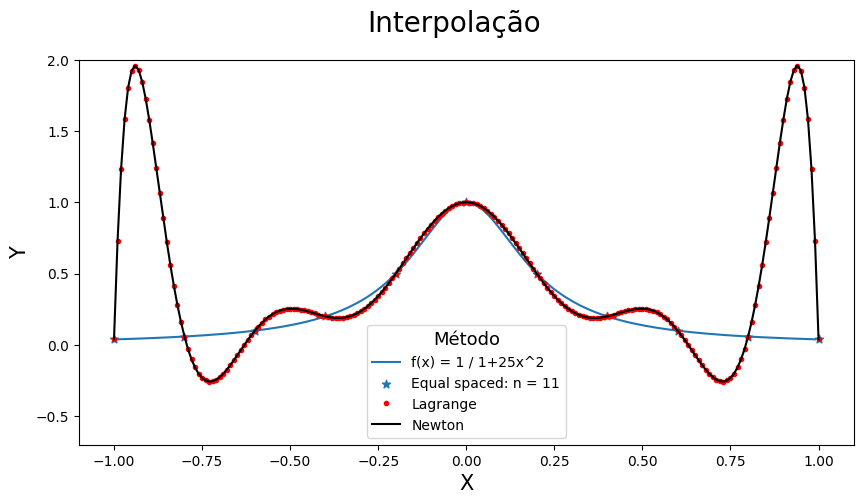

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

fig.suptitle('Interpolação', fontsize=20)

ax.plot(x_runge, f_runge, '-', label='f(x) = 1 / 1+25x^2')
ax.scatter(x_i, y_i, marker='*', label=f'Equal spaced: n = {len(x_i)}')
ax.plot(xs, L_lagrange, '.r', label='Lagrange')
ax.plot(xs, L_newton, '-k', label='Newton')

ax.set_xlabel('X', {'size': 15})
ax.set_ylabel('Y', {'size': 15})
ax.legend(title='Método', title_fontsize=13)

ax.set_ylim(-0.7, 2)

plt.show()

In [7]:
x_i = np.linspace(-1,1, 21)
y_i = [fRungPhen(x) for x in x_i]

interpolate = Interpolate(x_i, y_i)

In [8]:
x_runge = np.arange(-1,1,0.01)
f_runge = [fRungPhen(x) for x in x_runge]

xs = np.arange(-1,1.01,0.01)

L_lagrange = [interpolate.lagrange(x) for x in xs]
L_newton = [interpolate.newton(x) for x in xs]

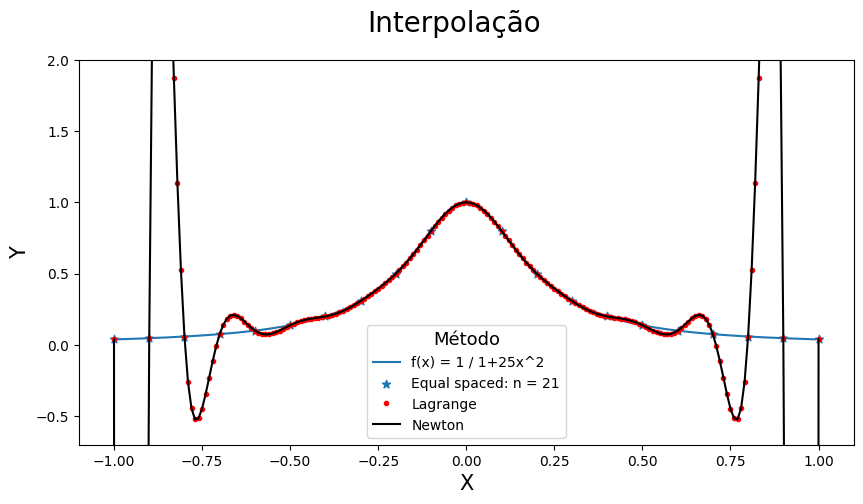

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

fig.suptitle('Interpolação', fontsize=20)

ax.plot(x_runge, f_runge, '-', label='f(x) = 1 / 1+25x^2')
ax.scatter(x_i, y_i, marker='*', label=f'Equal spaced: n = {len(x_i)}')
ax.plot(xs, L_lagrange, '.r', label='Lagrange')
ax.plot(xs, L_newton, '-k', label='Newton')

ax.set_xlabel('X', {'size': 15})
ax.set_ylabel('Y', {'size': 15})
ax.legend(title='Método', title_fontsize=13)

ax.set_ylim(-0.7, 2)

plt.show()

In [10]:
x_cheb = Interpolate.chebychev_nodes(-1.1,1,16)
y_cheb = [fRungPhen(x) for x in x_cheb]

xs = np.arange(-1,1.01,0.01)

interpolate = Interpolate(x_cheb, y_cheb)
L_cheb = [interpolate.lagrange(x) for x in xs]

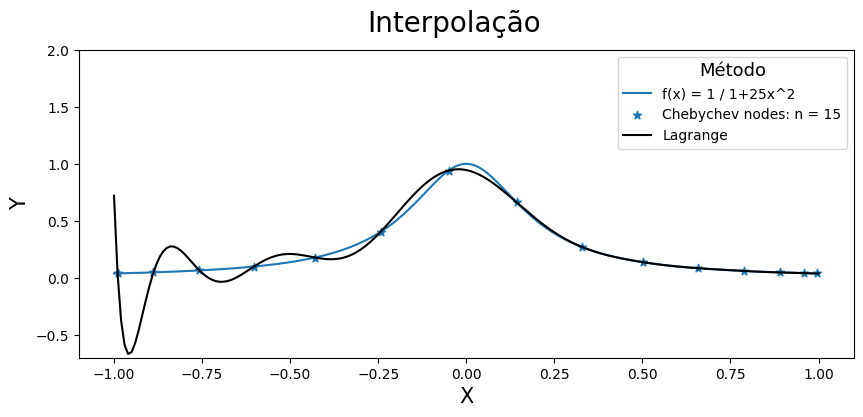

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

fig.suptitle('Interpolação', fontsize=20)

ax.plot(x_runge, f_runge, '-', label='f(x) = 1 / 1+25x^2')
ax.scatter(x_cheb, y_cheb, marker='*', label=f'Chebychev nodes: n = {len(x_cheb)}')
ax.plot(xs, L_cheb, '-k', label='Lagrange')

ax.set_xlabel('X', {'size': 15})
ax.set_ylabel('Y', {'size': 15})
ax.legend(title='Método', title_fontsize=13)

ax.set_ylim(-0.7, 2)

plt.show()

In [12]:
x_cheb = Interpolate.chebychev_nodes(-1,1,22)
y_cheb = [fRungPhen(x) for x in x_cheb]

xs = np.arange(-1,1.01,0.01)

interpolate = Interpolate(x_cheb, y_cheb)
L_cheb = [interpolate.lagrange(x) for x in xs]

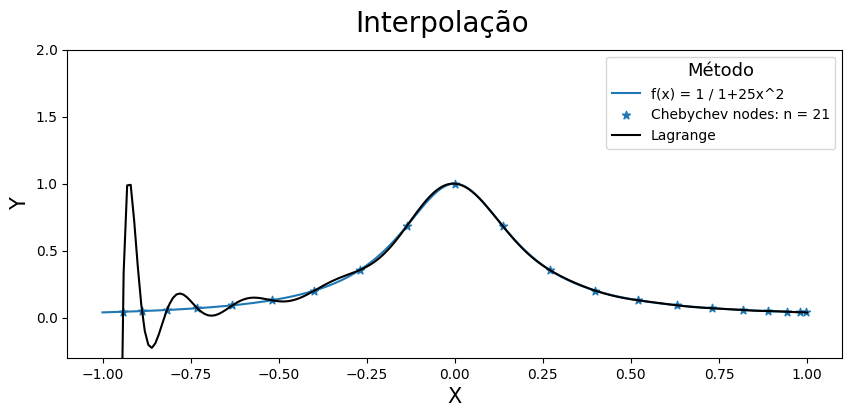

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

fig.suptitle('Interpolação', fontsize=20)

ax.plot(x_runge, f_runge, '-', label='f(x) = 1 / 1+25x^2')
ax.scatter(x_cheb, y_cheb, marker='*', label=f'Chebychev nodes: n = {len(x_cheb)}')
ax.plot(xs, L_cheb, '-k', label='Lagrange')

ax.set_xlabel('X', {'size': 15})
ax.set_ylabel('Y', {'size': 15})
ax.legend(title='Método', title_fontsize=13)

ax.set_ylim(-0.3, 2)

plt.show()

#### Questão 3 (Minimos Quadrados)